# SDF Sampler (3D)

[This in still under development]

In [1]:
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import imageio
import tqdm
from IPython.display import Video

from sdf_sampler.sampler import SDF_3DSampler
from sdf_sampler.utils import sample_2D_grid, plot_sdf, plot_scatter, plot_scatter_redblue
from sdf_sampler.utils import plot_sdf_values, volume_rendering

from sdf.mesh import sample_slice

## Create a sampler and use it to generate a random sdf

*N* defines the tree depth used to combine primitives and operations.

In [2]:
sampler = SDF_3DSampler(N=4)

primitives not found, so looking for default ones
operations not found, so looking for default ones
transform not found, so looking for default ones


In [3]:
[p['name'] for p in sampler.primitives.values()]

['plane',
 'sphere',
 'ellipsoid',
 'box',
 'wireframe box',
 'cylinder',
 'capped cylinder',
 'rounded cylinder',
 'capped cone',
 'capsule',
 'torus',
 'pyramid',
 'tetrahedron',
 'octahedron',
 'dodecahedron',
 'icosahedron']

In [4]:
[o['name'] for o in sampler.operations.values()]

['union',
 'intersection',
 'blend',
 'negate_union',
 'negate_intersection',
 'difference']

**Some observations about the operations:**

"Negate" operations will generate some kind of "interior" SDF if this is something that can be said about SDFs. The reason is that default primitives are more likely representing volumes created inside a cubic space with boundaries (-1,-1,-1) to (1, 1, 1), but when negating a SDF in this subspace we obtain a universe that presents more interior (negative values) than exterior space (positive values). But the resulting SDF=0 keeps being the same with "negate" operations.

Intersection could lead to vanish two shapes that were created with so much efford. But this operation open the possibity to create incredible SDFs. So, depending of the experiment in question it is important to think about what we want to obtain from the sampler.

**Take a sample**

Samples are based on *primitives*, primitives *operations*, and *transforms* operations defined when creating the sampler. By default, a sampler will tend to create SDF sample with values=0 morelikely in a world with boundaries between (-1,-1,-1) to (1, 1, 1).

In [5]:
sample = sampler()

## Visualize it

We can use underlying methods from sdf library to explore a slice of it.

Warning: if the sampler failed to generate a good sample (I believe by a concatenation of bad scaling factors) then the sdf will be moved far away from origin and its values will be large. Until solving the issue we can sort this issue taking another sample.

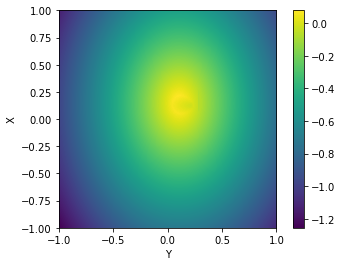

In [6]:
# forcing boundaries helps to avoid problems with weird samples
bounds = ((-1,-1,-1),(1,1,1))
sample.sdf().show_slice(z=0, w=512, h=512, bounds=bounds)

In [7]:
a, extent, axes = sample_slice(sample.sdf(), w=512, h=512, z=0.0, bounds=bounds)

In [8]:
a.min(), a.max()

(-1.2551610744718227, 0.07967330636019183)

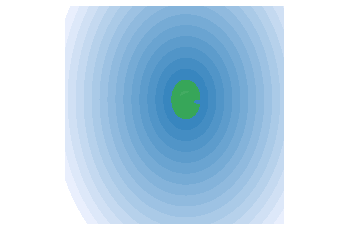

In [9]:
plot_sdf_values(a, w=512, h=512)

We can use the underlying library to export the mesh using marching cubes

In [10]:
outdir = 'content'
os.makedirs(outdir, exist_ok=True)

In [11]:
stl_filename = os.path.join(outdir, 'sample3D.stl')
sample.sdf().save(stl_filename, samples=2**26, bounds=bounds)

min -1, -1, -1
max 1, 1, 1
step 0.00492157, 0.00492157, 0.00492157
73560059 samples in 2197 batches with 16 workers
  100% (2197 of 2197) [##############################] 0:00:06 0:00:00    
2129 skipped, 38 empty, 30 nonempty
78852 triangles in 6.04504 seconds


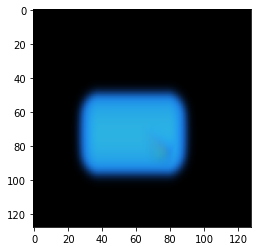

In [12]:
image = volume_rendering(sample.sdf())
plt.imshow(image)
plt.show()

In [13]:
vid = 1
video_name = os.path.join(outdir, f'volume_rendering_{vid:02}.mp4') 
frames = []
thetas = np.linspace(0, np.pi*2, 24)
bar = tqdm.tqdm(thetas)
for i, theta in enumerate(bar):
    bar.set_description(f'volume rendering {i} with theta={theta:.2f}')
    image = volume_rendering(sample.sdf(), theta=theta)
    frames.append(image)
frames = (np.array(frames + frames[::-1])*255).astype(np.uint8)
imageio.mimwrite(video_name, np.array(frames), fps=10, macro_block_size=8, quality=8)

volume rendering 23 with theta=6.28: 100%|█████████████████████████████████████████████| 24/24 [00:44<00:00,  1.84s/it]


In [14]:
Video(video_name)

In [15]:
video_name

'content\\volume_rendering_01.mp4'

In [16]:
def create_transfer_function(rgb_gaussians_loc=(0.1, 0.0, -0.1)):
    def transfer_function(x):
        rc, gc, bc = rgb_gaussians_loc
        r = 1.0*np.exp( -(x - rc)**2/0.01 )   +  0.1*np.exp( -(x - gc)**2/0.01 ) +  0.10*np.exp( -(x - bc)**2/0.01 )
        g = 0.1*np.exp( -(x - rc)**2/0.01 )   +  1.0*np.exp( -(x - gc)**2/0.02 ) +  0.10*np.exp( -(x - bc)**2/0.01 )
        b = 0.1*np.exp( -(x - rc)**2/0.01 )   +  0.1*np.exp( -(x - gc)**2/0.01 ) +  1.00*np.exp( -(x - bc)**2/0.01 )
        a = 0.005*np.exp( -(x - rc)**2/0.01 ) +  0.6*np.exp( -(x - gc)**2/0.01 ) +  0.01*np.exp( -(x - bc)**2/0.01 )
        return r,g,b,a
    return transfer_function

In [17]:
vid = 2
video_name = os.path.join(outdir, f'volume_rendering_{vid:02}.mp4') 
frames = []
thetas = np.linspace(0, np.pi*2, 24)
bar = tqdm.tqdm(thetas)
rgb_gaussians_loc = np.array([0.0, 0.0, 0.0])
dx = np.linspace(0, 1, len(thetas))
for i, theta in enumerate(bar):
    bar.set_description(f'volume rendering {i} with theta={theta:.2f}')
    rgb_gaussians_loc[0] = dx[i]
    rgb_gaussians_loc[2] = -dx[i]
    image = volume_rendering(sample.sdf(), theta=theta, transfer_function=create_transfer_function(rgb_gaussians_loc))
    frames.append(image)
frames = (np.array(frames + frames[::-1])*255).astype(np.uint8)
imageio.mimwrite(video_name, np.array(frames), fps=10, macro_block_size=8, quality=8)

volume rendering 23 with theta=6.28: 100%|█████████████████████████████████████████████| 24/24 [00:43<00:00,  1.83s/it]


In [18]:
Video(video_name)

In [19]:
def create_transfer_function(rgb_gaussians_loc=(0.1, 0.0, -0.1), alpha_green=1.0):
    def transfer_function(x):
        rc, gc, bc = rgb_gaussians_loc
        ag = alpha_green
        r = 1.0*np.exp( -(x - rc)**2/0.01 )   +  0.1*np.exp( -(x - gc)**2/0.01 ) +  0.10*np.exp( -(x - bc)**2/0.01 )
        g = 0.1*np.exp( -(x - rc)**2/0.01 )   +  1.0*np.exp( -(x - gc)**2/0.02 ) +  0.10*np.exp( -(x - bc)**2/0.01 )
        b = 0.1*np.exp( -(x - rc)**2/0.01 )   +  0.1*np.exp( -(x - gc)**2/0.01 ) +  1.00*np.exp( -(x - bc)**2/0.01 )
        a = 0.05*np.exp( -(x - rc)**2/0.01 )  +   ag*np.exp( -(x - gc)**2/0.01 ) + 0.01*np.exp( -(x - bc)**2/0.01 )
        return r,g,b,a
    return transfer_function

In [20]:
vid = 3
video_name = os.path.join(outdir, f'volume_rendering_{vid:02}.mp4') 
frames = []
thetas = np.linspace(0, np.pi*2, 48)
bar = tqdm.tqdm(thetas)
rgb_gaussians_loc = np.array([0.0, 0.0, 0.0])
dx = np.linspace(0, 1, len(thetas//2))
for i, theta in enumerate(bar):
    bar.set_description(f'volume rendering {i} with theta={theta:.2f}')
    rgb_gaussians_loc[0] = dx[i % len(dx)]
    rgb_gaussians_loc[2] = -dx[i % len(dx)]
    alpha_green = dx[-((i % len(dx))+1)]
    image = volume_rendering(sample.sdf(), theta=theta,
                             transfer_function=create_transfer_function(rgb_gaussians_loc, alpha_green))
    frames.append(image)
frames = (np.array(frames + frames[::-1])*255).astype(np.uint8)
imageio.mimwrite(video_name, np.array(frames), fps=10, macro_block_size=8, quality=8)

volume rendering 47 with theta=6.28: 100%|█████████████████████████████████████████████| 48/48 [01:39<00:00,  2.07s/it]


In [21]:
Video(video_name)

Increase volume grid resolution to 256 for volume rendering

In [22]:
vid = 4
video_name = os.path.join(outdir, f'volume_rendering_{vid:02}.mp4') 
frames = []
thetas = np.linspace(0, np.pi*2, 48)
bar = tqdm.tqdm(thetas)
rgb_gaussians_loc = np.array([0.0, 0.0, 0.0])
dx = np.linspace(0, 1, len(thetas//2))
for i, theta in enumerate(bar):
    rgb_gaussians_loc[0] = dx[i % len(dx)]
    rgb_gaussians_loc[2] = -dx[i % len(dx)]*.2
    alpha_green = dx[-((i % len(dx))+1)]
    locs = ', '.join([f'{g:.03f}' for g in rgb_gaussians_loc])
    bar.set_description(f'volume rendering {i} with theta={theta:.2f} alpha_green={alpha_green:.02f} locs=({locs})')
    image = volume_rendering(sample.sdf(), N=256, theta=theta,
                             transfer_function=create_transfer_function(rgb_gaussians_loc, alpha_green))
    frames.append(image)
frames = (np.array(frames + frames[::-1])*255).astype(np.uint8)
imageio.mimwrite(video_name, np.array(frames), fps=10, macro_block_size=8, quality=8)

volume rendering 47 with theta=6.28 alpha_green=0.00 locs=(1.000, 0.000, -0.200): 100%|█| 48/48 [11:55<00:00, 14.91s/it


In [23]:
Video(video_name)

## Show how the SDF was created

In [24]:
print(sample.root)


                   ____________________________________________________________~∩(~∪(py,∩(∪(rcy,do),rcy)),rcy)_8__
                  /                                                                                               \
   __~∪(py,∩(∪(rcy,do),rcy))_7_______________________________                                                    rcy_4
  /                                                          \
py_1                                        __________∩(∪(rcy,do),rcy)_6__
                                           /                              \
                                   __∪(rcy,do)_5_                        rcy_3
                                  /              \
                               rcy_4             do_2



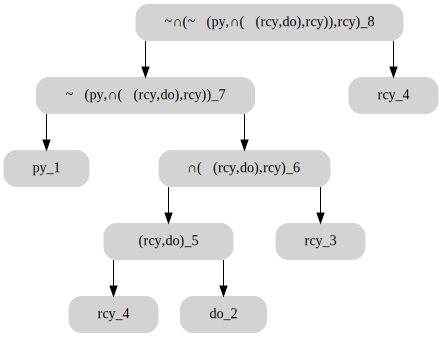

In [25]:
sample.root

Every sample needs to keep track of the sdf used to generate values because they will be used on demand

In [26]:
len(sample.sdfs_list)

9

This allows us to see the pieces that helped to created the final sdf

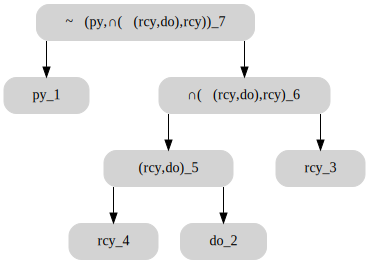

In [27]:
sample.root.left

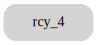

In [28]:
sample.right

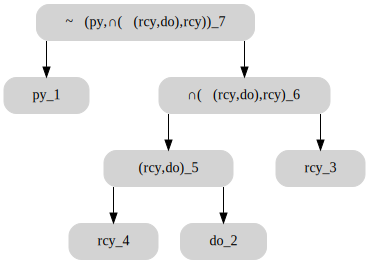

In [29]:
sample.left

### How to use the SDF to extract its values for coordinates?

By default every generated shape tries to be in range (-1, 1) but it doesn't mean we can't explore the whole sdf space

In [30]:
# create a list of coordinates than belongs to a 20x20 grid in range -5 to 5
grid = sample_2D_grid(resolution=20, low=-5, high=5)
# add 2 more dimension
grid = np.hstack((grid, np.zeros_like(grid[:,0:1])))
grid.shape

(400, 3)

In [31]:
# get the sdf values for these coordinates
sdf_values = sample().f(grid)
sdf_values = sdf_values.flatten()

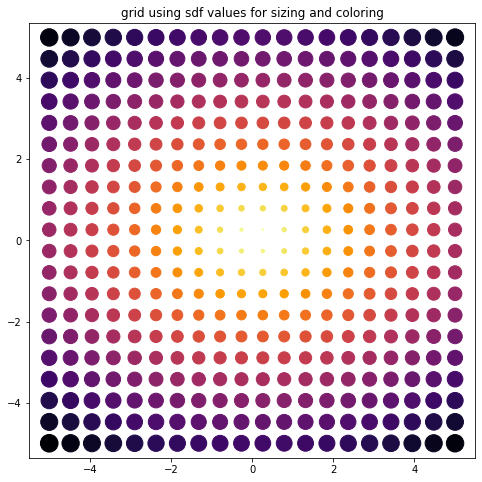

In [32]:
fig = plt.figure(figsize=(8,8))
size = np.abs(sdf_values*50)

plt.scatter(grid[:,0], grid[:,1], s=size, c=sdf_values, cmap='inferno')

# fix axis
plt.axis('equal')
plt.title('grid using sdf values for sizing and coloring')
plt.show()

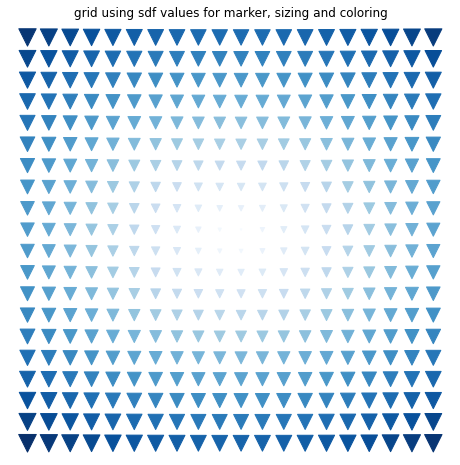

In [33]:
# similar but chainging shape base of sdf value sign

fig = plt.figure(figsize=(8,8))

pos = (sdf_values >= 0)
neg = (sdf_values < 0)

size = np.abs(sdf_values*50)
for marker, cond, cmap in zip(['^','v'], [pos, neg], ['Reds', 'Blues_r']):
    plt.scatter(grid[cond,0], grid[cond,1], s=size[cond], c=sdf_values[cond], cmap=cmap, marker=marker)

# fix axis
plt.axis('equal')
plt.axis('off')
plt.title('grid using sdf values for marker, sizing and coloring')
plt.show()

We can increase the resolution looking closer into range -1 to 1

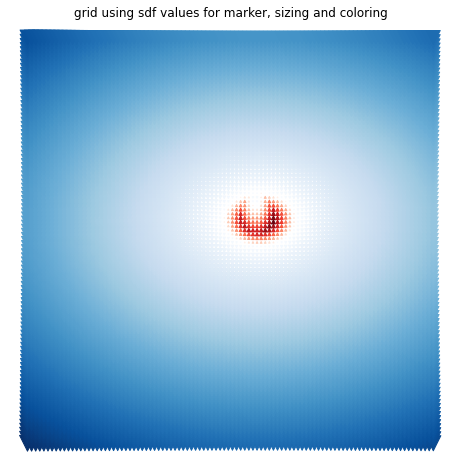

In [34]:
grid = sample_2D_grid(resolution=100, low=-1, high=1)
grid = np.hstack((grid, np.zeros_like(grid[:,0:1])))
sdf_values = sample().f(grid)
sdf_values = sdf_values.flatten()

fig = plt.figure(figsize=(8,8))

pos = (sdf_values >= 0)
neg = (sdf_values < 0)

size = np.abs(sdf_values*200)
for marker, cond, cmap in zip(['^','v'], [pos, neg], ['Reds', 'Blues_r']):
    plt.scatter(grid[cond,0], grid[cond,1], s=size[cond], c=sdf_values[cond], cmap=cmap, marker=marker)

# fix axis
plt.axis('equal')
plt.axis('off')
plt.title('grid using sdf values for marker, sizing and coloring')
plt.show()

Let's use the sampler like a sampler

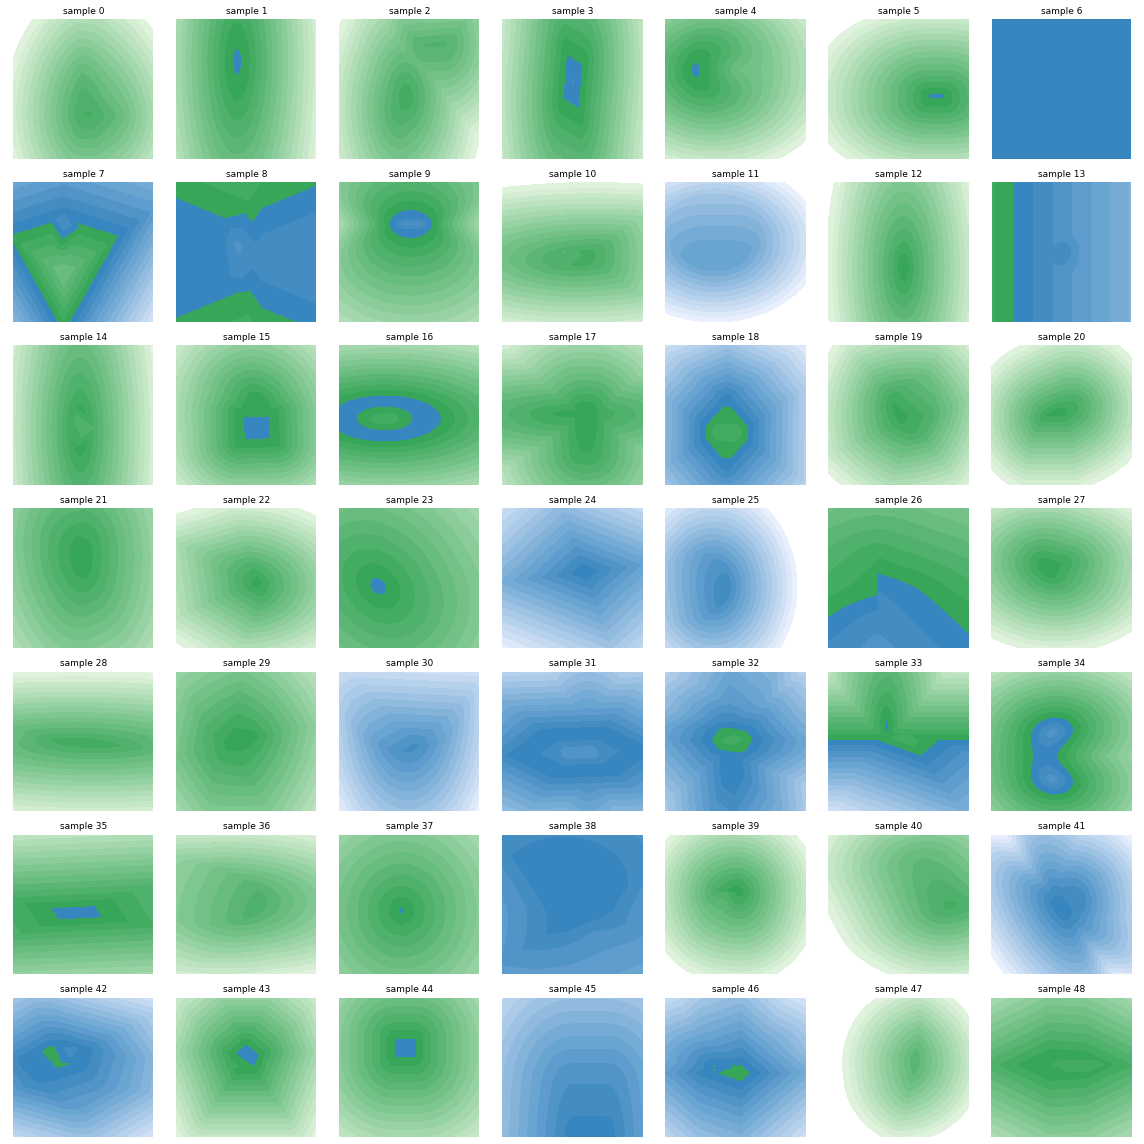

In [35]:
fig, axes = plt.subplots(7,7,figsize=(16,16))
axes = axes.flatten().tolist()
for i, ax in enumerate(axes):
    sample = sampler()
    a, extent, axes = sample_slice(sample.sdf(), w=256, h=256, z=0.0, bounds=((-1,-1,-1), (1,1,1)))
    plot_sdf_values(a, w=256, h=256, ax=ax, title=f'sample {i}')
plt.tight_layout()
plt.show()

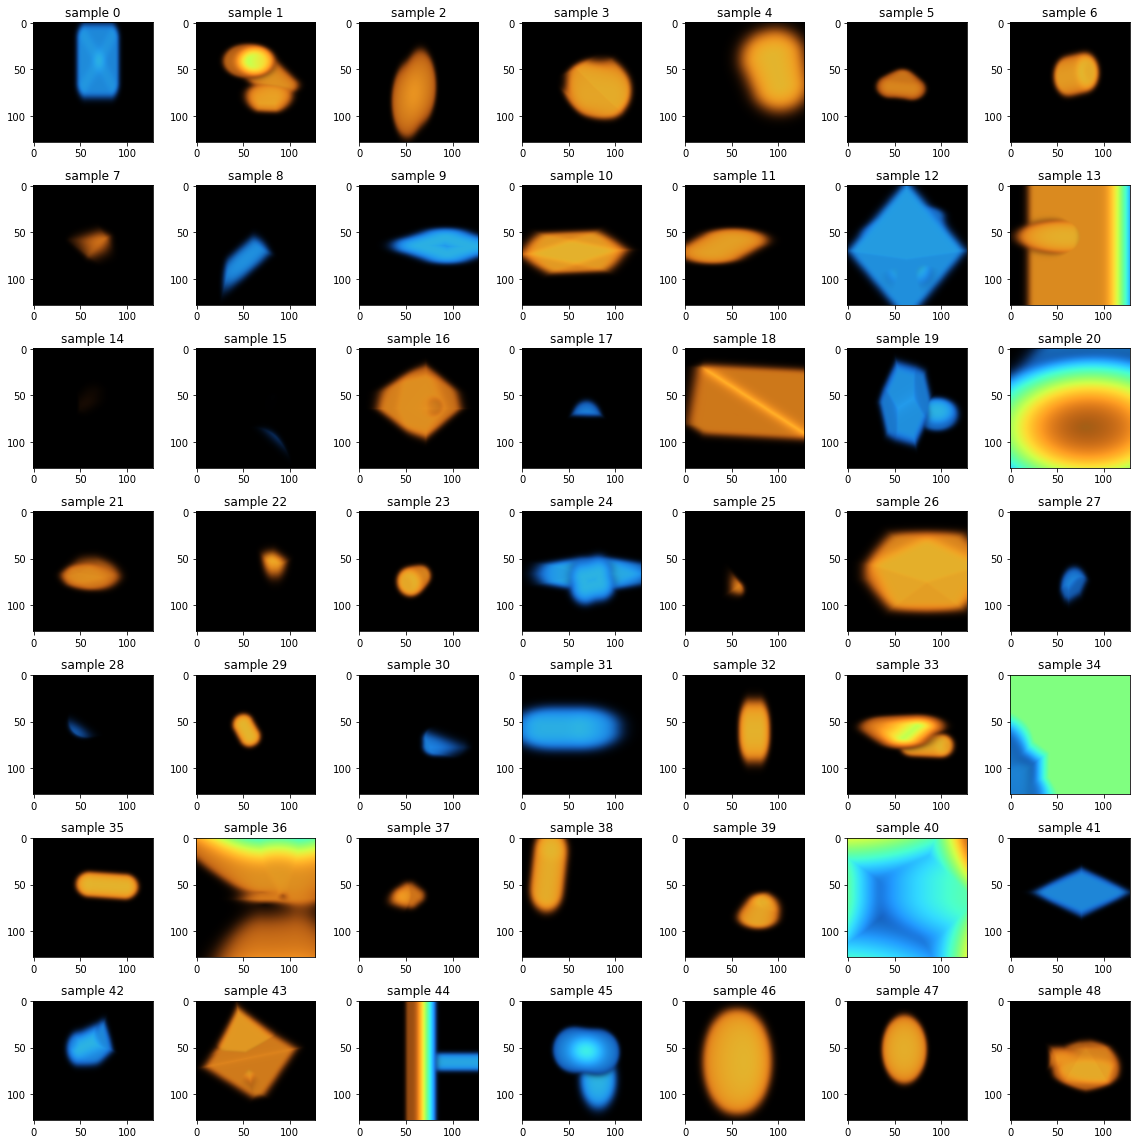

In [36]:
fig, axes = plt.subplots(7,7,figsize=(16,16))
axes = axes.flatten().tolist()
for i, ax in enumerate(axes):
    sample = sampler()
    image = volume_rendering(sample.sdf())
    ax.imshow(image)
    ax.set_title(f'sample {i}')
plt.tight_layout()
plt.show()

Last sample composition

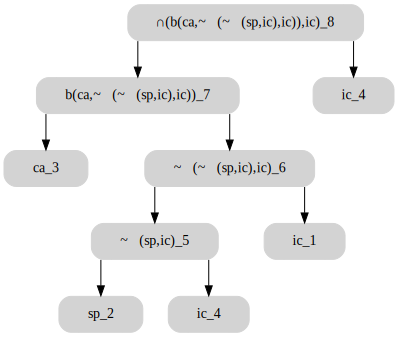

In [37]:
sample.root

## How to change the sampler

We can change:
- primitives: sdf_sampler.primitives.primitives_3d
- operations: sdf_sampler.operations.operations_3d
- transforms: sdf_sampler.transforms.transforms_3d

Let's try to generate samples a bit bias to replication and simmetry. I nice sdf operation is the circular_array, but it is a unary operation and in this binary tree the operations are more likely ... binary operations. So, the easy way to do that with a simple change is to create a custom transforms_3d function. This function was created to translate, rotate and scale a sdf.

And this time we will:
- avoid "negate" operations that will help to avoid generation large negative spaces.
- avoid 'difference' operations to obtain bigger sdfs

In [61]:
import sdf
# import default transforms used by the SDF Sampler
from sdf_sampler.transforms import transforms_3d
from sdf_sampler.operations import operations_3d

In [62]:
def transforms_3d_custom(s):
    # first we apply standard transforms (translate, rotate and scale)
    s = transforms_3d(s)
    # and sometimes we replicate the sdf as a circular shape
    if np.random.rand() > 0.5:
        # number of duplicated shapes
        count = np.random.choice([2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
        # shifted distance
        offset = np.random.rand()*.75
        #print(f'circular_array(count={count}, offset={offset:.2f})!!!')
        s = sdf.d3.circular_array(s, count=count, offset=offset)
    return s

In [63]:
# remove negate operations

operations_3d_custom = operations_3d.copy()
for k in operations_3d.keys():
    print(f"{k}: {operations_3d[k]['name']}")
    if '~' in k or '-' == k:
        print(f"  removing operation {operations_3d[k]['name']}")
        del operations_3d_custom[k]

∪: union
∩: intersection
b: blend
~∪: negate_union
  removing operation negate_union
~∩: negate_intersection
  removing operation negate_intersection
-: difference
  removing operation difference


In [64]:
# we create a new sampler with our custom transforms_3d for replication
sampler = SDF_3DSampler(operations=operations_3d_custom, transforms=transforms_3d_custom, N=4)

primitives not found, so looking for default ones


In [65]:
sample = sampler()

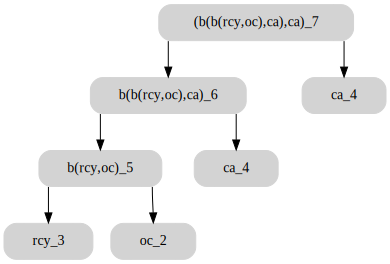

In [66]:
sample.root

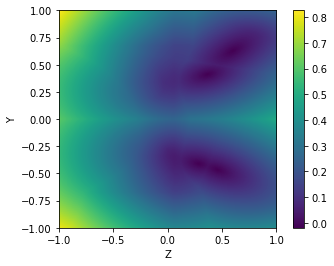

In [67]:
sample.sdf().show_slice(x=0, w=512, h=512, bounds=bounds)

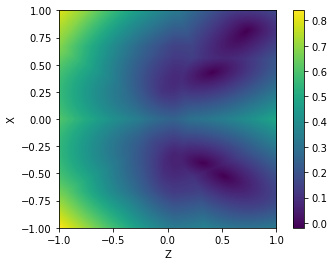

In [68]:
sample.sdf().show_slice(y=0, w=512, h=512, bounds=bounds)

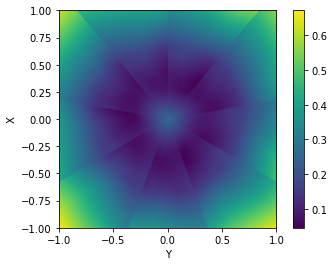

In [69]:
# forcing boundaries helps to avoid problems with weird samples
sample.sdf().show_slice(z=0, w=512, h=512, bounds=bounds)

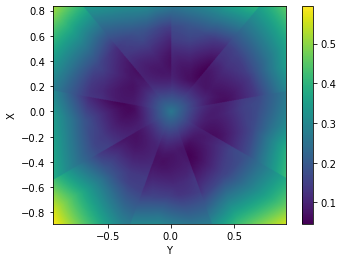

In [70]:
# Not using bounds will force looking for them if possible
try:
    sample.sdf().show_slice(z=0, w=512, h=512)
except:
    print('it was not possible to find the boundaries')

Explore sdf components in the sample tree

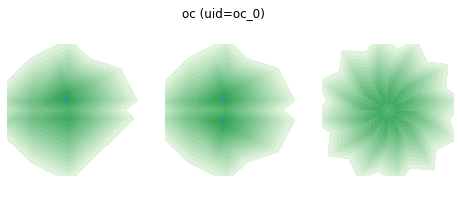

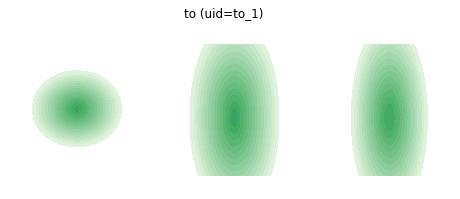

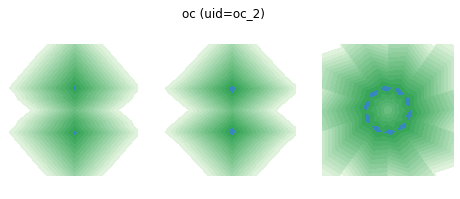

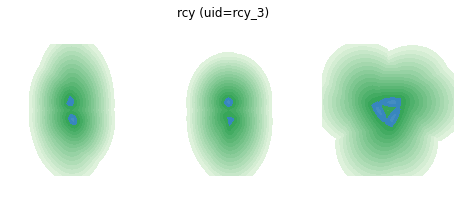

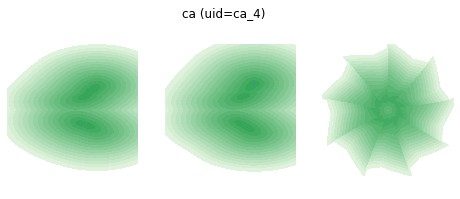

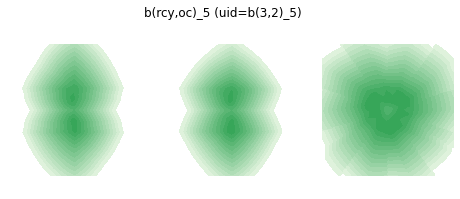

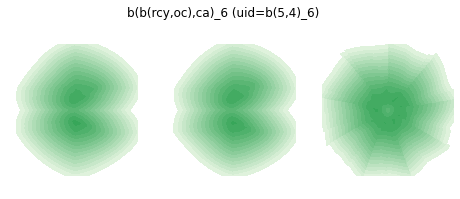

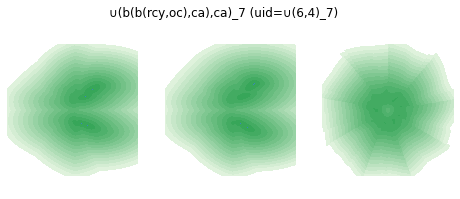

In [71]:
w, h = 512, 512
# increase boundaries for exploration
bounds = ((-2,-2,-2), (2, 2, 2))
for comp in sample.sdfs_list:
    # show 3 slices of current sdf for x=0, y=0 and z=0 respectively
    fig, axes = plt.subplots(1,3,figsize=(8,3))
    axes = axes.flatten().tolist()
    for i, params in enumerate([{'x': 0}, {'y': 0}, {'z':0}]):
        a, extent, axes_names = sample_slice(comp['sdf'], w=w, h=h, **params, bounds=bounds)
        ax = axes[i]
        plot_sdf_values(a, w=w, h=h, ax=ax)
    plt.suptitle(f"{comp['name']} (uid={comp['uid']})")
    plt.show()

In [72]:
from glob import glob

def generate_video(psdf, video_name, resolution=128, nframes=24):
    if '.mp4' not in video_name: video_name = f'{video_name}.mp4'
    frames = []
    thetas = np.linspace(0, np.pi*2, nframes)
    bar = tqdm.tqdm(thetas)
    for i, theta in enumerate(bar):
        bar.set_description(f'volume rendering {i} with theta={theta:.2f}')
        image = volume_rendering(psdf, N=resolution, theta=theta)
        frames.append(image)
    frames = (np.array(frames + frames[::-1])*255).astype(np.uint8)
    imageio.mimwrite(video_name, np.array(frames), fps=10, macro_block_size=8, quality=8)
    return video_name

In [75]:
resolution = 256 # will take some time to generate this video (grid = 256**3)
video_name = generate_video(sample.sdf(), os.path.join(outdir, f'custom_transforms_3d_sample_{resolution}'), resolution)
print(video_name)
Video(video_name)

volume rendering 23 with theta=6.28: 100%|█████████████████████████████████████████████| 24/24 [11:36<00:00, 29.00s/it]


content\custom_transforms_3d_sample_256.mp4


## STL

### Export as STL

In [73]:
bounds = ((-1,-1,-1),(1, 1, 1))
stl_filename = os.path.join(outdir, 'custom_transforms_3d_sample.stl')
sample.sdf().save(stl_filename, samples=2**26, bounds=bounds)

min -1, -1, -1
max 1, 1, 1
step 0.00492157, 0.00492157, 0.00492157
73560059 samples in 2197 batches with 16 workers
  100% (2197 of 2197) [##############################] 0:00:20 0:00:00    
1851 skipped, 207 empty, 139 nonempty
234428 triangles in 19.9183 seconds


### Visualize STL

We can use a library like jupyter-k3d to see the exported file

In [74]:
import k3d

with open(stl_filename, 'rb') as stl:
    data = stl.read()

plt_stl = k3d.stl(data, color=0x33aaff)

plot = k3d.plot()
plot += plt_stl
plot.display()

Output()

### Some thoughts for ML usage

SDF Sampler might be used to train ML models in many ways.

For instance, just a moment ago was published the paper "SDF-StyleGAN: Implicit SDF-Based StyleGAN for 3D Shape Generation". One could try to replicate the experiment using the SDF Sampler to obtain infinite learning data without the need of a huge dataset of meshes.

We could use the SDF-Sampler with a small tree depth (N=1) to learn basic primitives and with time create more complex samplers.

We can start by using simpler primitives' operations and transforms to guide the learning of the model.

We could induce symmetric learning just by playing with the sampler:
- by using primitives with this property: primitive and underlying primitive sampler
- by customizing the global transforms operations like we did implementing the circular array to replicate a sdf.
  - But we might also reduce rotations to orthogonal ones (PI/2)
  
Over time we could increase the complexity of the samples in many ways:
- increasing the tree depth.
- increasing the number of sdf primitives.
- increasing the number of sdf (binary) operations.
- using custom global transforms operations.
- SDFs are easily to be rounded. In example, the underlying sdf library has the dilate operation that can be used to "round" shapes.

It would be convenient to start by thinking about what you need from the model, its task. And then how to get the most of the SDF Sampler.